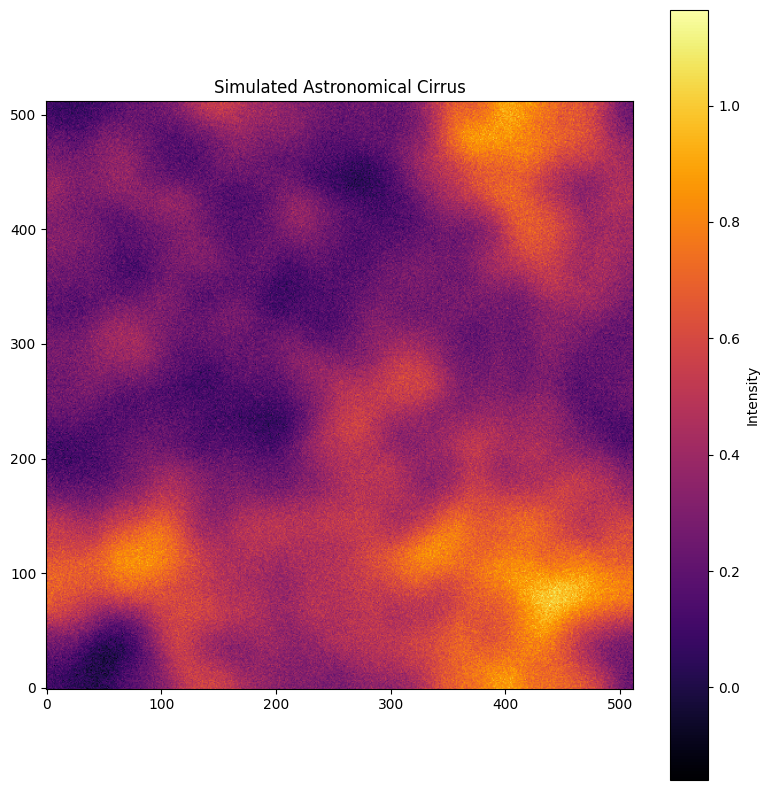

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def generate_fbm(size, hurst_exponent):
    """
    Generate a 2D fractional Brownian motion (fBm) field using a power-law
    power spectrum.

    Parameters:
        size (tuple): Dimensions of the output map (ny, nx).
        hurst_exponent (float): Hurst exponent controlling spatial correlations.

    Returns:
        np.ndarray: Normalized 2D fBm field in the range [0, 1].
    """
    ny, nx = size
    kx = np.fft.fftfreq(nx).reshape(1, nx)
    ky = np.fft.fftfreq(ny).reshape(ny, 1)
    k_squared = kx**2 + ky**2
    k_squared[0, 0] = 1.0  # Prevent division by zero

    # Power spectrum scaling: 1 / k^(H + 1)
    scaling = k_squared ** (-(hurst_exponent + 1) / 2.0)
    scaling[0, 0] = 0  # Remove DC component

    # Complex Gaussian noise
    noise = np.random.normal(size=(ny, nx)) + 1j * np.random.normal(size=(ny, nx))

    # Apply power-law scaling in Fourier domain
    fbm_fourier = noise * scaling
    fbm = np.fft.ifft2(fbm_fourier).real

    # Normalize to [0, 1]
    fbm = (fbm - np.min(fbm)) / (np.max(fbm) - np.min(fbm))
    return fbm


def simulate_cirrus(size, hurst=0.7, beam_fwhm=5.0, noise_level=0.01):
    """
    Simulate a realistic astronomical cirrus map.

    Parameters:
        size (tuple): Map dimensions (ny, nx).
        hurst (float): Hurst exponent for fBm generation.
        beam_fwhm (float): Smoothing kernel width (in pixels).
        noise_level (float): Standard deviation of Gaussian observational noise.

    Returns:
        np.ndarray: Simulated cirrus map.
    """
    # Generate fractional Brownian motion
    fbm = generate_fbm(size, hurst)

    # Smooth with Gaussian kernel (simulates telescope beam)
    smoothed_fbm = gaussian_filter(fbm, sigma=beam_fwhm)

    # Log-normal transformation to introduce skewness
    log_fbm = np.exp(smoothed_fbm)
    log_fbm = (log_fbm - np.min(log_fbm)) / (np.max(log_fbm) - np.min(log_fbm))

    # Add Gaussian noise
    noisy_fbm = log_fbm + np.random.normal(scale=noise_level, size=size)

    return noisy_fbm


def plot_cirrus(cirrus_map, title="Simulated Astronomical Cirrus"):
    """
    Display the cirrus map using matplotlib.

    Parameters:
        cirrus_map (np.ndarray): 2D array of intensity values.
        title (str): Plot title.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cirrus_map, origin="lower", cmap="inferno")
    plt.colorbar(label="Intensity")
    plt.title(title)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Parameters
    size = (512, 512)            # Image size in pixels
    hurst_exponent = 0.7         # Controls structure
    beam_fwhm = 10               # Telescope beam width in pixels
    noise_level = 0.05           # Simulated observational noise

    # Generate and plot cirrus
    cirrus_map = simulate_cirrus(size, hurst=hurst_exponent,
                                  beam_fwhm=beam_fwhm, noise_level=noise_level)
    plot_cirrus(cirrus_map)